#Librerias

In [3]:
pip install shap catboost

In [4]:
from catboost import CatBoostClassifier, CatBoostRegressor
import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from shapely import box
from shapely.geometry import Polygon,box,Point
import IPython
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score,roc_curve,confusion_matrix,log_loss
from imblearn.over_sampling import SMOTE
import fiona
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
import shap
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.utils.class_weight import compute_class_weight
import scipy as sp
from pyproj import Transformer

In [5]:
merger = pd.read_parquet("train_3_3_final.parquet")
merger=merger.dropna()

src_crs = 'epsg:32718'
target_crs = 'epsg:4326'


transformer = Transformer.from_crs(src_crs, target_crs)

lon, lat = transformer.transform(merger['x'].values, merger['y'].values)

# Add the new columns to the DataFrame
merger['longitud'] = lon
merger['latitud'] = lat

merger = merger.drop(["x","y"],axis=1)

In [6]:
merger.head(5)

,cuadrilla,dia,incendio,geometry,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,...,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,longitud,latitud
0,0,1,0,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.533333,0.0,-38.432372,-73.942629
1,0,2,0,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.900000,0.0,-38.432372,-73.942629
2,0,3,0,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.175000,0.0,-38.432372,-73.942629
3,0,4,0,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.000000,0.0,-38.432372,-73.942629
4,0,5,0,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,...,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,17.825000,0.0,-38.432372,-73.942629


#Correlaciones

In [7]:
merger.shape

(1080035, 22)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


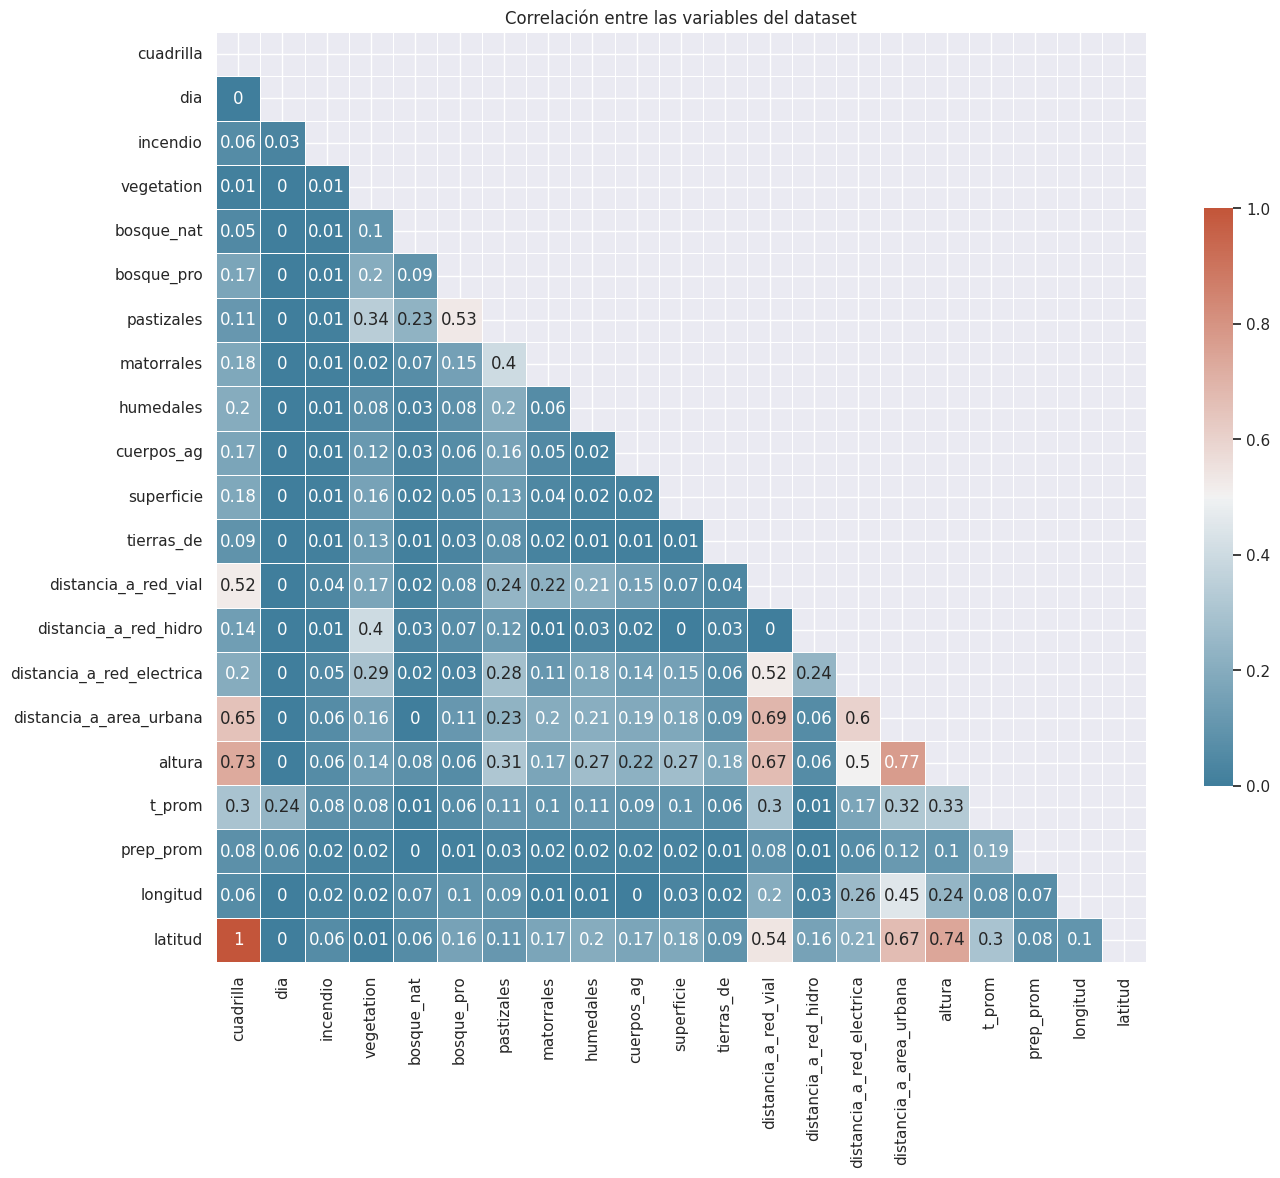

In [82]:
corr = np.abs(merger.corr()).round(2)
sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
# Draw the heatmap with the mask and correct aspect ratio
plt.title("Correlación entre las variables del dataset")
plt.show()

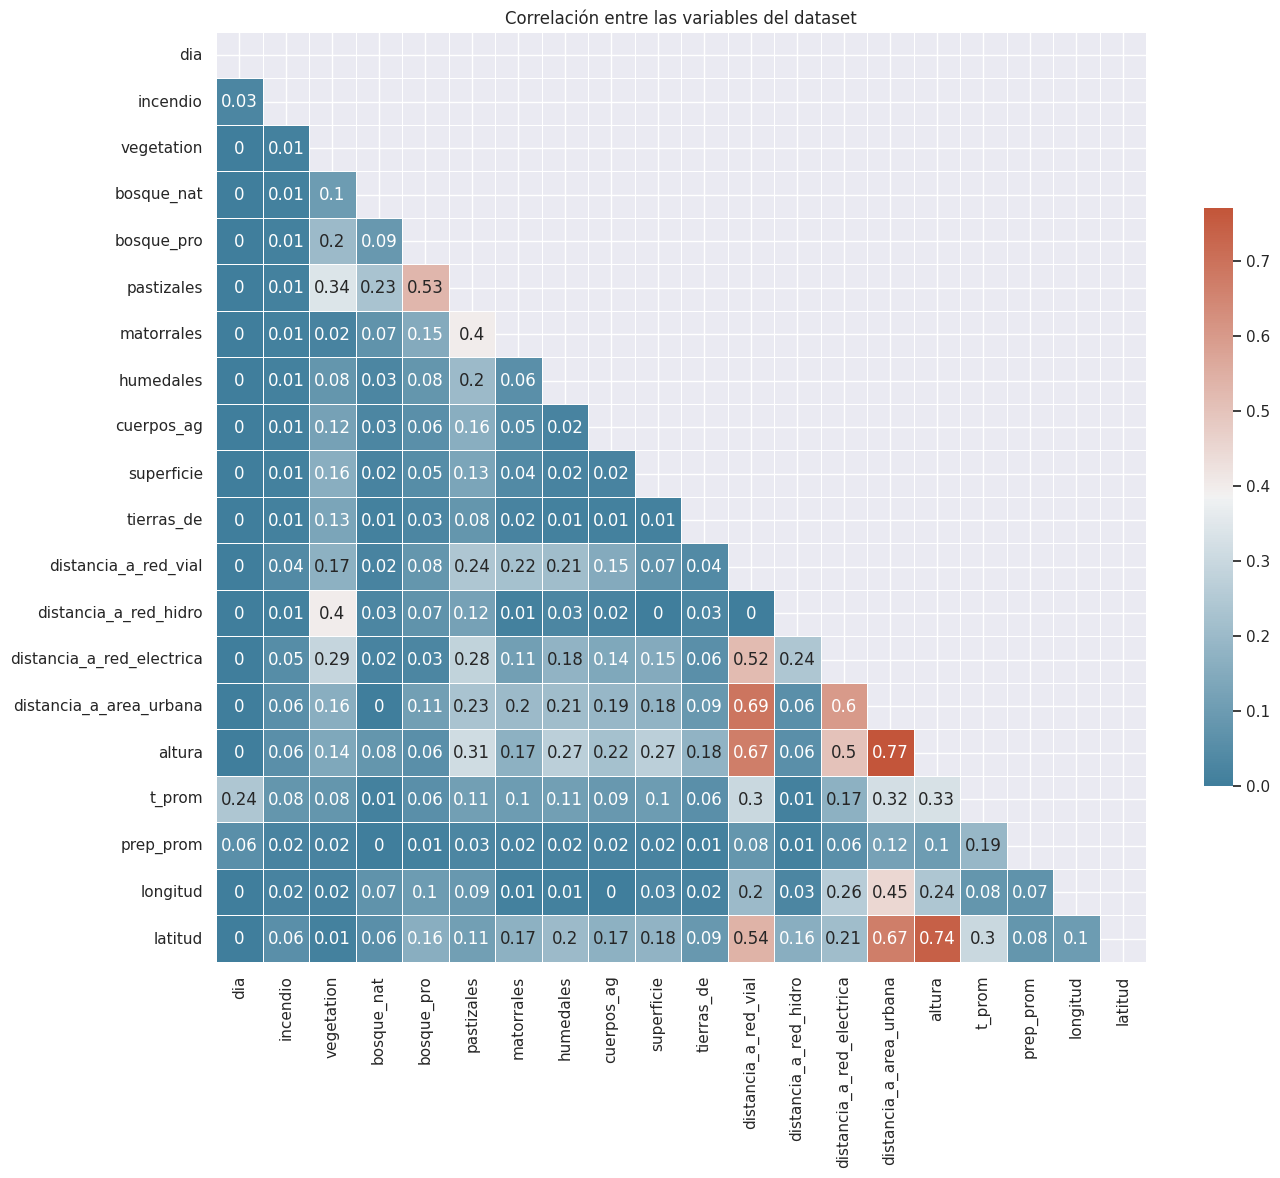

In [84]:
merger_clean = merger.drop(["cuadrilla","geometry"],axis=1)
corr = np.abs(merger_clean.corr()).round(2)
sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
# Draw the heatmap with the mask and correct aspect ratio
plt.title("Correlación entre las variables del dataset")
plt.show()

#Creación de conjuntos train y test

In [12]:
X = merger_clean.drop(['incendio'], axis=1)
y = merger_clean['incendio']
print(merger_clean["incendio"].value_counts())

0    1072716
1       7319
Name: incendio, dtype: int64


In [13]:
class_weights = dict({0: 1, 1: len(y) / sum(y)})
class_weights

{0: 1, 1: 147.56592430659927}

In [14]:

pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=0.55))])

no_escalar = X[["dia","vegetation","longitud","latitud"]]

X_esc = pd.DataFrame(MinMaxScaler().fit_transform(X.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_esc[["dia","vegetation","longitud","latitud"]] = no_escalar

X_train, X_test, y_train, y_test = train_test_split(X_esc, y, test_size=0.2, random_state=42)
X_resampled_train, y_resampled_train = pipeline.fit_resample(X_train, y_train)



In [81]:
from sklearn.feature_selection import chi2
chi2_stat, p_values = chi2(X_test.drop(["longitud","latitud"],axis=1), y_test)

# Display chi-square statistics and p-values for each feature
chi2_results = pd.DataFrame({'Feature': X_test.drop(["longitud","latitud"],axis=1).columns, 'Chi2': chi2_stat, 'P-Value': p_values})
print(chi2_results)

# Select features based on a significance level (e.g., 0.05)
significant_features = chi2_results[chi2_results['P-Value'] < 0.01]['Feature'].tolist()
print(significant_features)

                      Feature          Chi2        P-Value
0                  bosque_nat     33.613679   6.721837e-09
1                  bosque_pro     12.304585   4.518471e-04
2                  pastizales     13.276523   2.687504e-04
3                  matorrales     13.459797   2.437301e-04
4                   humedales      6.511903   1.071548e-02
5                  cuerpos_ag      0.829223   3.624974e-01
6                  superficie     19.677156   9.169093e-06
7                  tierras_de      6.570519   1.036817e-02
8        distancia_a_red_vial     91.751454   9.827605e-22
9       distancia_a_red_hidro      2.629122   1.049197e-01
10  distancia_a_red_electrica     89.929087   2.468511e-21
11    distancia_a_area_urbana    140.140172   2.480627e-32
12                     altura    125.617441   3.728579e-29
13                     t_prom    101.795184   6.156967e-24
14                  prep_prom     21.101962   4.354820e-06
15                        dia  10155.674102   0.000000e+

In [15]:
display(X_resampled_train)

,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,dia,vegetation,longitud,latitud
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.135371,0.009670,0.627846,0.534536,0.498312,0.564207,0.000000,92,446,-37.673918,-71.232601
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.113802,0.002055,0.249122,0.456050,0.407794,0.517119,0.000000,205,288,-37.817239,-71.497863
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034717,0.023897,0.350368,0.156978,0.001534,0.723233,0.000000,79,444,-38.128354,-73.365170
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.511925,0.016693,0.393585,0.247132,0.420988,0.103470,0.000000,246,318,-37.115473,-71.530486
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015478,0.005486,0.141283,0.095192,0.006444,0.651890,0.000000,310,289,-37.318388,-73.450591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330181,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.041755,0.011788,0.092031,0.057260,0.041252,0.750947,0.029144,325,280,-37.729647,-73.354037
1330182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020720,0.071305,0.041879,0.007318,0.009368,0.725092,0.063570,8,1500,-37.108720,-73.304260
1330183,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.075631,0.005462,0.195675,0.102563,0.042170,0.839481,0.000000,2,293,-37.011520,-72.276802
1330184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000628,0.009540,0.000000,0.000000,0.041731,0.670998,0.000000,81,347,-37.479196,-73.345493


In [16]:
print("dim dataset original",merger_clean.shape)
print("dim X resampled train",X_resampled_train.shape)
print("dim y resampled train",y_resampled_train.shape)
print("dim X test",X_test.shape)
print("dim y test",y_test.shape)

dim dataset original (1080035, 20)
dim X resampled train (1330186, 19)
dim y resampled train (1330186,)
dim X test (216007, 19)
dim y test (216007,)


In [17]:
y_resampled_train.value_counts()

0    858185
1    472001
Name: incendio, dtype: int64

In [18]:
y_test.value_counts()

0    214531
1      1476
Name: incendio, dtype: int64

#RFC

In [73]:
model_rfc = RandomForestClassifier(n_estimators=150,max_depth=90,min_samples_leaf=40,min_samples_split=45,criterion="log_loss"\
                                   ,class_weight={0:0.001,1:50})
model_rfc.fit(X_resampled_train, y_resampled_train)
y_pred_rfc = model_rfc.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rfc)

print('Precisión del modelo:', round(accuracy_rf,4))

print('Informe de clasificación:')

print(classification_report(y_test, y_pred_rfc))



Precisión del modelo: 0.7907
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    214531
           1       0.03      0.89      0.06      1476

    accuracy                           0.79    216007
   macro avg       0.51      0.84      0.47    216007
weighted avg       0.99      0.79      0.88    216007



auc: 0.9241950857216875


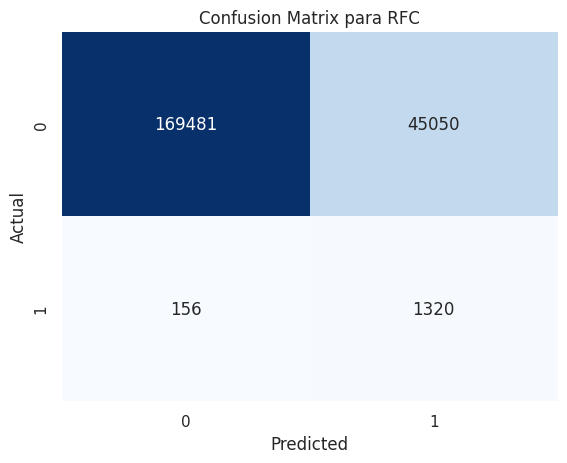

In [74]:
y_pred_proba_rfc = model_rfc.predict_proba(X_test)[:,1]
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_pred_proba_rfc)
auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)
print("auc:",auc_rfc)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(cm_rfc, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para RFC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

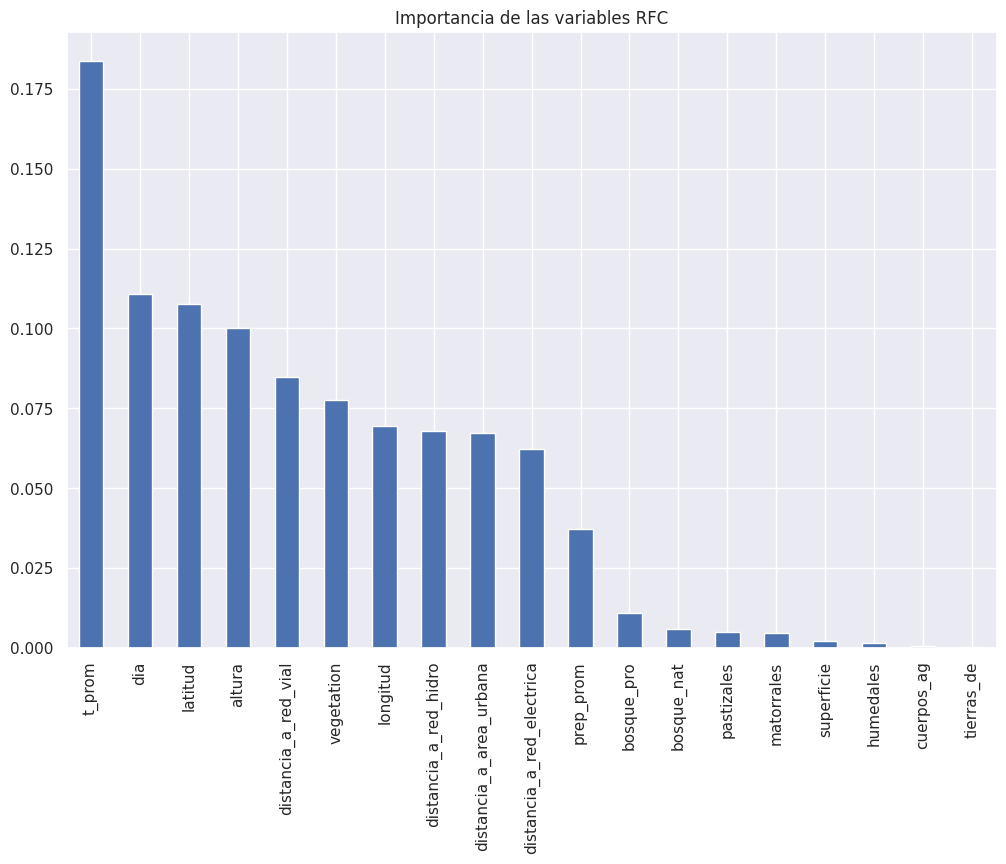

In [75]:
# Get feature importances
feature_importances = pd.Series(model_rfc.feature_importances_, index=X_test.columns)

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title("Importancia de las variables RFC")
plt.show()

#Logit

In [65]:
model_logit = LogisticRegression(solver="lbfgs",max_iter=1500,penalty="l2",warm_start=True)


model_logit.fit(X_resampled_train, y_resampled_train)
y_pred_logit = model_logit.predict(X_test)

accuracy_logit = accuracy_score(y_test, y_pred_logit)

print('Precisión del modelo:', round(accuracy_logit,4))

print('Informe de clasificación:')

print(classification_report(y_test, y_pred_logit))

y_pred_proba_logit = model_logit.predict_proba(X_test)[:,1]
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, y_pred_proba_logit)
auc_logit = roc_auc_score(y_test, y_pred_proba_logit)
print("auc:",auc_logit)



Precisión del modelo: 0.2252
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.22      0.36    214531
           1       0.01      1.00      0.02      1476

    accuracy                           0.23    216007
   macro avg       0.50      0.61      0.19    216007
weighted avg       0.99      0.23      0.36    216007

auc: 0.8571533252867897


In [30]:
"""from tqdm import tqdm
n_bootstrap = 100
bootstrap_coefs = np.zeros((n_bootstrap, len(model_logit.coef_[0])))
from sklearn.utils import resample
from scipy.stats import norm

for i in tqdm(range(n_bootstrap)):
    X_bootstrap, y_bootstrap = resample(X_resampled_train, y_resampled_train, random_state=i)

    # Fit logistic regression on the bootstrap sample
    logreg_model_bootstrap = LogisticRegression(solver="lbfgs",max_iter=700,warm_start=True,penalty="l2")
    logreg_model_bootstrap.fit(X_bootstrap, y_bootstrap)

    # Store coefficients
    bootstrap_coefs[i, :] = logreg_model_bootstrap.coef_

# Calculate standard errors from bootstrap samples
standard_errors = np.std(bootstrap_coefs, axis=0)

# Calculate z-scores and p-values
z_scores = model_logit.coef_[0] / standard_errors
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))
print(p_values)"""

'from tqdm import tqdm\nn_bootstrap = 100\nbootstrap_coefs = np.zeros((n_bootstrap, len(model_logit.coef_[0])))\nfrom sklearn.utils import resample\nfrom scipy.stats import norm\n\nfor i in tqdm(range(n_bootstrap)):\n    X_bootstrap, y_bootstrap = resample(X_resampled_train, y_resampled_train, random_state=i)\n\n    # Fit logistic regression on the bootstrap sample\n    logreg_model_bootstrap = LogisticRegression(solver="lbfgs",max_iter=700,warm_start=True,penalty="l2")\n    logreg_model_bootstrap.fit(X_bootstrap, y_bootstrap)\n\n    # Store coefficients\n    bootstrap_coefs[i, :] = logreg_model_bootstrap.coef_\n\n# Calculate standard errors from bootstrap samples\nstandard_errors = np.std(bootstrap_coefs, axis=0)\n\n# Calculate z-scores and p-values\nz_scores = model_logit.coef_[0] / standard_errors\np_values = 2 * (1 - norm.cdf(np.abs(z_scores)))\nprint(p_values)'

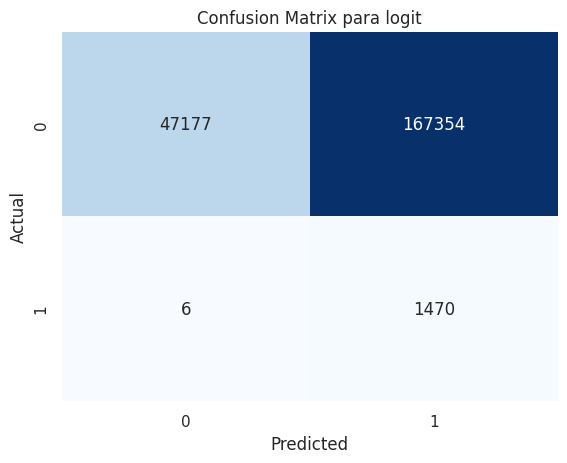

In [66]:
cm_logit = confusion_matrix(y_test, y_pred_logit)
sns.heatmap(cm_logit, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para logit")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [32]:
coef_per_variable =model_logit.coef_
df = pd.DataFrame(data=coef_per_variable, columns=X_test.columns)
display(df)

,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,dia,vegetation,longitud,latitud
0,-1.154186,-0.795486,-0.762947,-0.340032,-0.100535,-0.286594,-0.386583,-0.129358,-7.383239,-4.655193,-0.932539,-8.313287,-6.416331,7.050825,-3.466096,-0.000236,-0.000977,0.354381,-0.179218


#Catboost

In [68]:
#iterations=1000, depth=8, learning_rate=1, loss_function='Logloss'
model_cat = CatBoostClassifier(iterations=1500, depth=8, learning_rate=0.03, loss_function='Logloss')
model_cat.fit(X_resampled_train, y_resampled_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=100)
y_pred_cat = model_cat.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_cat)

print('Precisión del modelo:', round(accuracy,4))


print('Informe de clasificación:')

print(classification_report(y_test, y_pred_cat))

y_pred_proba_cat = model_cat.predict_proba(X_test)[:,1]
fpr_cat, tpr_cat, thresholds = roc_curve(y_test, y_pred_proba_cat)
auc_cat = roc_auc_score(y_test, y_pred_proba_cat)

print("auc:",auc_cat)




0:	learn: 0.6195959	test: 0.6814571	best: 0.6814571 (0)	total: 545ms	remaining: 13m 37s
100:	learn: 0.0328320	test: 1.0193503	best: 0.6628577 (4)	total: 34.2s	remaining: 7m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6628576706
bestIteration = 4

Shrink model to first 5 iterations.
Precisión del modelo: 0.0976
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.09      0.17    214531
           1       0.01      1.00      0.01      1476

    accuracy                           0.10    216007
   macro avg       0.50      0.55      0.09    216007
weighted avg       0.99      0.10      0.17    216007

auc: 0.8785984022574282


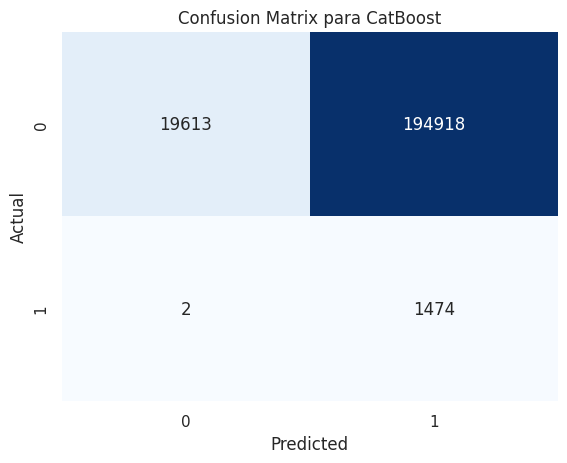

In [69]:
cm_cat = confusion_matrix(y_test, y_pred_cat)
sns.heatmap(cm_cat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#AUC de los 3 modelos

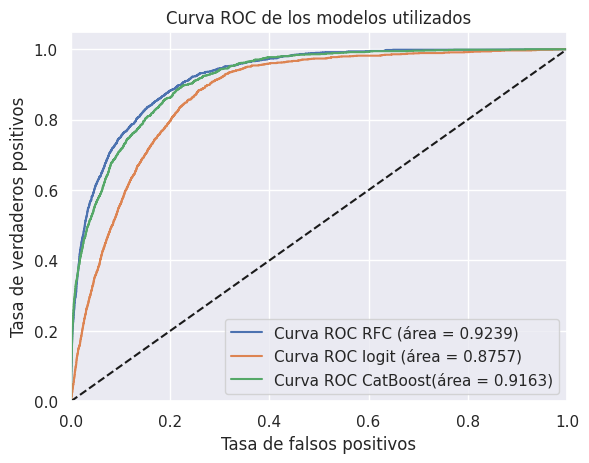

In [35]:
plt.plot(fpr_rfc, tpr_rfc, label='Curva ROC RFC (área = %0.4f)' % auc_rfc)
plt.plot(fpr_logit, tpr_logit, label='Curva ROC logit (área = %0.4f)' % auc_logit)
plt.plot(fpr_cat, tpr_cat, label='Curva ROC CatBoost(área = %0.4f)' % auc_cat)


plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

# Etiquetas de los ejes y título

plt.xlabel('Tasa de falsos positivos')

plt.ylabel('Tasa de verdaderos positivos')

plt.title('Curva ROC de los modelos utilizados')

plt.legend(loc="lower right")

# Mostrar la gráfica

plt.show()


# Holdout

In [36]:
hold_out = pd.read_parquet("holdout_3_3_final.parquet")
hold_out = hold_out.drop(["cuadrilla","geometry"],axis=1)


src_crs = 'epsg:32718'
target_crs = 'epsg:4326'


transformer = Transformer.from_crs(src_crs, target_crs)

lon, lat = transformer.transform(hold_out['x'].values, hold_out['y'].values)

# Add the new columns to the DataFrame
hold_out['longitud'] = lon
hold_out['latitud'] = lat

hold_out = hold_out.drop(["x","y"],axis=1)

In [37]:
hold_out.head(4)

,dia,incendio,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,longitud,latitud
0,1,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.533333,0.0,-38.432372,-73.942629
1,2,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.900000,0.0,-38.432372,-73.942629
2,3,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,18.175000,0.0,-38.432372,-73.942629
3,4,0,1500,0,0,0,0,0,0,0,0,2396.263833,36622.87188,40962.548384,10123.192195,0.0,19.000000,0.0,-38.432372,-73.942629


In [76]:
print(hold_out.shape)

(1080035, 20)


In [38]:
X_holdout = hold_out.drop(['incendio'], axis=1)
no_escalar_holdout = X_holdout[["dia","vegetation","longitud","latitud"]]
X_holdout = pd.DataFrame(MinMaxScaler().fit_transform(X_holdout.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X_holdout.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_holdout[["dia","vegetation","longitud","latitud"]] = no_escalar_holdout
y_holdout = hold_out['incendio']
X_holdout = X_holdout.reindex(X_test.columns, axis=1)

In [39]:
display(X_resampled_train)

,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,t_prom,prep_prom,dia,vegetation,longitud,latitud
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.135371,0.009670,0.627846,0.534536,0.498312,0.564207,0.000000,92,446,-37.673918,-71.232601
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.113802,0.002055,0.249122,0.456050,0.407794,0.517119,0.000000,205,288,-37.817239,-71.497863
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034717,0.023897,0.350368,0.156978,0.001534,0.723233,0.000000,79,444,-38.128354,-73.365170
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.511925,0.016693,0.393585,0.247132,0.420988,0.103470,0.000000,246,318,-37.115473,-71.530486
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015478,0.005486,0.141283,0.095192,0.006444,0.651890,0.000000,310,289,-37.318388,-73.450591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330181,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.041755,0.011788,0.092031,0.057260,0.041252,0.750947,0.029144,325,280,-37.729647,-73.354037
1330182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020720,0.071305,0.041879,0.007318,0.009368,0.725092,0.063570,8,1500,-37.108720,-73.304260
1330183,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.075631,0.005462,0.195675,0.102563,0.042170,0.839481,0.000000,2,293,-37.011520,-72.276802
1330184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000628,0.009540,0.000000,0.000000,0.041731,0.670998,0.000000,81,347,-37.479196,-73.345493


In [78]:
y_holdout.value_counts()

0    1078487
1       1548
Name: incendio, dtype: int64

In [40]:
y_pred_rfc_holdout = model_rfc.predict(X_holdout)
y_pred_logit_holdout = model_logit.predict(X_holdout)
y_pred_cat_holdout = model_cat.predict(X_holdout)

Precisión del modelo rfc holdout: 0.7879
Precisión del modelo logit holdout: 0.8358
Precisión del modelo cat holdout: 0.9774
Informe de clasificación rfc holdout:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88   1078487
           1       0.01      0.92      0.01      1548

    accuracy                           0.79   1080035
   macro avg       0.50      0.85      0.45   1080035
weighted avg       1.00      0.79      0.88   1080035

Informe de clasificación logit holdout:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91   1078487
           1       0.01      0.85      0.01      1548

    accuracy                           0.84   1080035
   macro avg       0.50      0.84      0.46   1080035
weighted avg       1.00      0.84      0.91   1080035

Informe de clasificación cat holdout:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1078

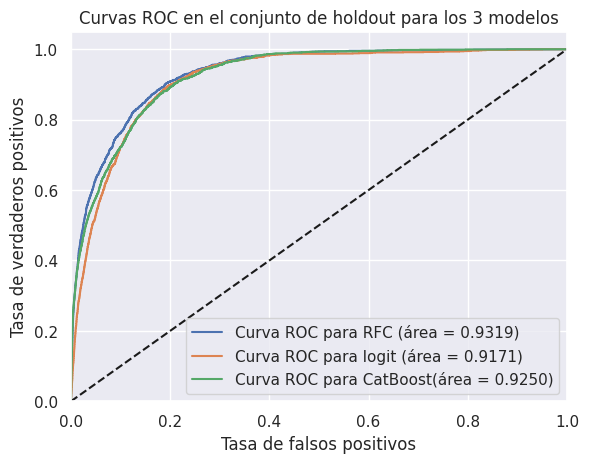

In [41]:

accuracy_rfc_holdout = accuracy_score(y_holdout, y_pred_rfc_holdout)
accuracy_logit_holdout = accuracy_score(y_holdout, y_pred_logit_holdout)
accuracy_cat_holdout = accuracy_score(y_holdout, y_pred_cat_holdout)
print('Precisión del modelo rfc holdout:', round(accuracy_rfc_holdout,4))
print('Precisión del modelo logit holdout:', round(accuracy_logit_holdout,4))
print('Precisión del modelo cat holdout:', round(accuracy_cat_holdout,4))


print('Informe de clasificación rfc holdout:')
print(classification_report(y_holdout, y_pred_rfc_holdout))
print('Informe de clasificación logit holdout:')
print(classification_report(y_holdout, y_pred_logit_holdout))
print('Informe de clasificación cat holdout:')
print(classification_report(y_holdout, y_pred_cat_holdout))


y_pred_proba_rfc_holdout = model_rfc.predict_proba(X_holdout)[:,1]
y_pred_proba_logit_holdout = model_logit.predict_proba(X_holdout)[:,1]
y_pred_proba_cat_holdout = model_cat.predict_proba(X_holdout)[:,1]



fpr_rfc_holdout, tpr_rfc_holdout, thresholds_rfc_holdout = roc_curve(y_holdout, y_pred_proba_rfc_holdout)
auc_rfc_holdout = roc_auc_score(y_holdout, y_pred_proba_rfc_holdout)

fpr_logit_holdout, tpr_logit_holdout, thresholds_logit_holdout = roc_curve(y_holdout, y_pred_proba_logit_holdout)
auc_logit_holdout = roc_auc_score(y_holdout, y_pred_proba_logit_holdout)

fpr_cat_holdout, tpr_cat_holdout, thresholds_cat_holdout = roc_curve(y_holdout, y_pred_proba_cat_holdout)
auc_cat_holdout = roc_auc_score(y_holdout, y_pred_proba_cat_holdout)

plt.plot(fpr_rfc_holdout, tpr_rfc_holdout, label='Curva ROC para RFC (área = %0.4f)' % auc_rfc_holdout)
plt.plot(fpr_logit_holdout, tpr_logit_holdout, label='Curva ROC para logit (área = %0.4f)' % auc_logit_holdout)
plt.plot(fpr_cat_holdout, tpr_cat_holdout, label='Curva ROC para CatBoost(área = %0.4f)' % auc_cat_holdout)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('Tasa de falsos positivos')

plt.ylabel('Tasa de verdaderos positivos')

plt.title('Curvas ROC en el conjunto de holdout para los 3 modelos')

plt.legend(loc="lower right")

# Mostrar la gráfica

plt.show()


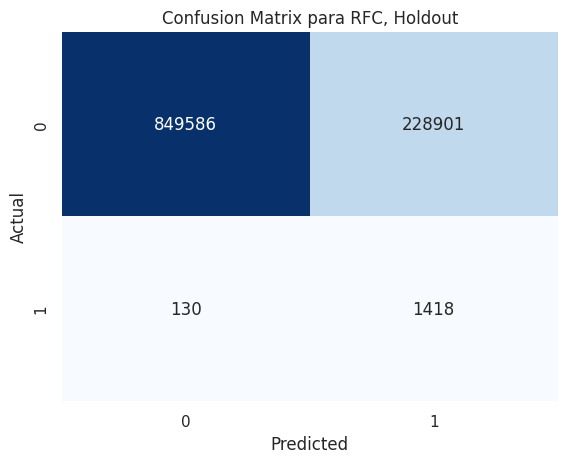

In [42]:
cm_rfc_holdout = confusion_matrix(y_holdout, y_pred_rfc_holdout)
sns.heatmap(cm_rfc_holdout, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para RFC, Holdout")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

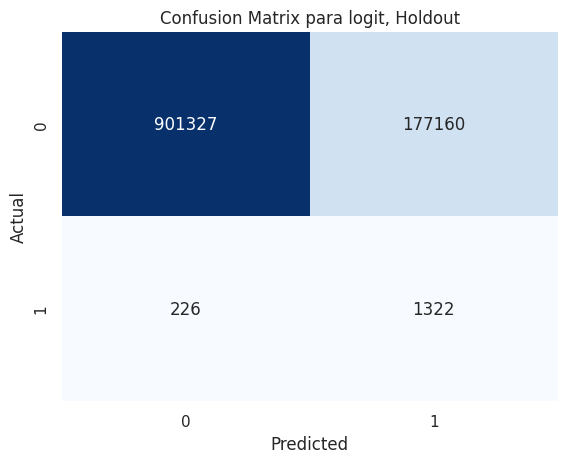

In [43]:
cm_logit_holdout = confusion_matrix(y_holdout, y_pred_logit_holdout)
sns.heatmap(cm_logit_holdout, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para logit, Holdout")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

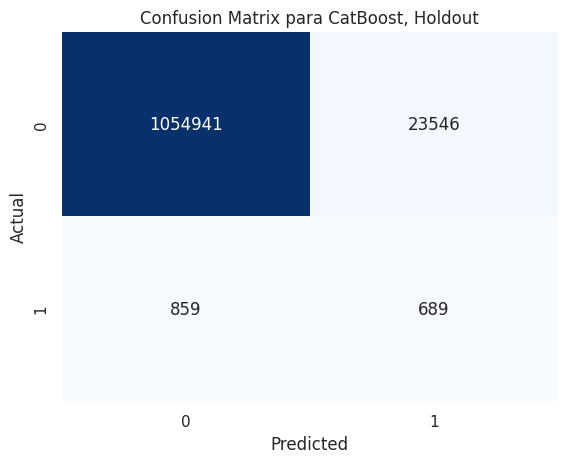

In [44]:
cm_cat_holdout = confusion_matrix(y_holdout, y_pred_cat_holdout)
sns.heatmap(cm_cat_holdout, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para CatBoost, Holdout")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Enero

## Entrenamiento full dataset

In [45]:
train_enero = pd.read_parquet("/content/df_completo_3_3_final.parquet")
train_enero = train_enero.drop(["cuadrilla","geometry"],axis=1)
src_crs = 'epsg:32718'
target_crs = 'epsg:4326'


transformer = Transformer.from_crs(src_crs, target_crs)

lon, lat = transformer.transform(train_enero['x'].values, train_enero['y'].values)

# Add the new columns to the DataFrame
train_enero['longitud'] = lon
train_enero['latitud'] = lat

train_enero = train_enero.drop(["x","y"],axis=1)

X_enero = train_enero.drop(['incendio'], axis=1)
y_enero = train_enero['incendio']
print(X_enero.shape)

(1080035, 19)


In [46]:
pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=0.55))])

no_escalar_enero = X_enero[["dia","vegetation","longitud","latitud"]]

X_esc_enero = pd.DataFrame(MinMaxScaler().fit_transform(X_enero.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X_enero.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_esc_enero[["dia","vegetation","longitud","latitud"]] = no_escalar

X_train_enero, X_test_enero, y_train_enero, y_test_enero = train_test_split(X_esc_enero, y_enero, test_size=0.2, random_state=42)
X_resampled_train_enero, y_resampled_train_enero = pipeline.fit_resample(X_train_enero, y_train_enero)
print("dim dataset original para enero",X_enero.shape)
print("dim X resampled train para enero",X_resampled_train_enero.shape)
print("dim y resampled train para enero",y_resampled_train_enero.shape)
print("dim X test para enero",X_test_enero.shape)
print("dim y test para enero",y_test_enero.shape)


dim dataset original para enero (1080035, 19)
dim X resampled train para enero (1328546, 19)
dim y resampled train para enero (1328546,)
dim X test para enero (216007, 19)
dim y test para enero (216007,)


In [79]:
y_test_enero.value_counts()

0    214265
1      1742
Name: incendio, dtype: int64

## RFC Full

In [47]:
model_rfc_enero = RandomForestClassifier(n_estimators=150,max_depth=90,min_samples_leaf=40,min_samples_split=45,criterion="log_loss"\
                                   ,class_weight={0:0.001,1:50})
model_rfc_enero.fit(X_resampled_train_enero, y_resampled_train_enero)
y_pred_rfc_enero = model_rfc_enero.predict(X_test_enero)

accuracy_rf_enero = accuracy_score(y_test_enero, y_pred_rfc_enero)

print('Precisión del modelo:', round(accuracy_rf_enero,4))

print('Informe de clasificación:')

print(classification_report(y_test_enero, y_pred_rfc_enero))


Precisión del modelo: 0.7776
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.78      0.87    214265
           1       0.03      0.91      0.06      1742

    accuracy                           0.78    216007
   macro avg       0.52      0.84      0.47    216007
weighted avg       0.99      0.78      0.87    216007



auc: 0.9250712733459374


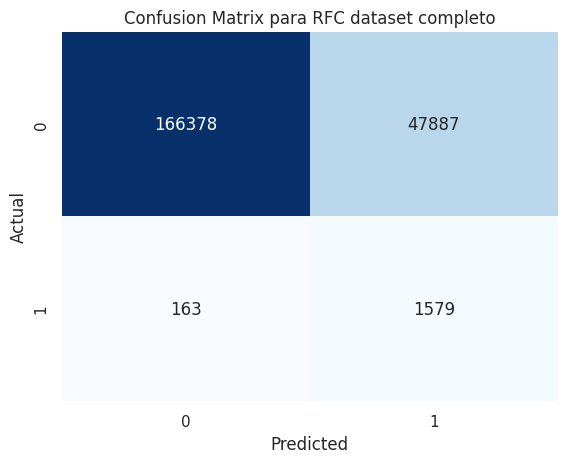

In [48]:
y_pred_proba_rfc_enero = model_rfc_enero.predict_proba(X_test_enero)[:,1]
fpr_rfc_enero, tpr_rfc_enero, thresholds_rfc_enero = roc_curve(y_test_enero, y_pred_proba_rfc_enero)
auc_rfc_enero = roc_auc_score(y_test_enero, y_pred_proba_rfc_enero)
print("auc:",auc_rfc_enero)
cm_rfc_enero = confusion_matrix(y_test_enero, y_pred_rfc_enero)
sns.heatmap(cm_rfc_enero, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para RFC dataset completo")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Logit Full

In [49]:
model_logit_enero = LogisticRegression(solver="lbfgs",max_iter=1500,penalty="l2",warm_start=True)


model_logit_enero.fit(X_resampled_train_enero, y_resampled_train_enero)
y_pred_logit_enero = model_logit.predict(X_test_enero)

accuracy_logit_enero = accuracy_score(y_test_enero, y_pred_logit_enero)

print('Precisión del modelo:', round(accuracy_logit_enero,4))

print('Informe de clasificación:')

print(classification_report(y_test_enero, y_pred_logit_enero))

y_pred_proba_logit_enero = model_logit_enero.predict_proba(X_test_enero)[:,1]
fpr_logit_enero, tpr_logit_enero, thresholds_logit_enero = roc_curve(y_test, y_pred_proba_logit_enero)
auc_logit_enero = roc_auc_score(y_test_enero, y_pred_proba_logit_enero)
print("auc:",auc_logit_enero)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Precisión del modelo: 0.8388
Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    214265
           1       0.04      0.74      0.07      1742

    accuracy                           0.84    216007
   macro avg       0.52      0.79      0.49    216007
weighted avg       0.99      0.84      0.90    216007

auc: 0.8812652379588426


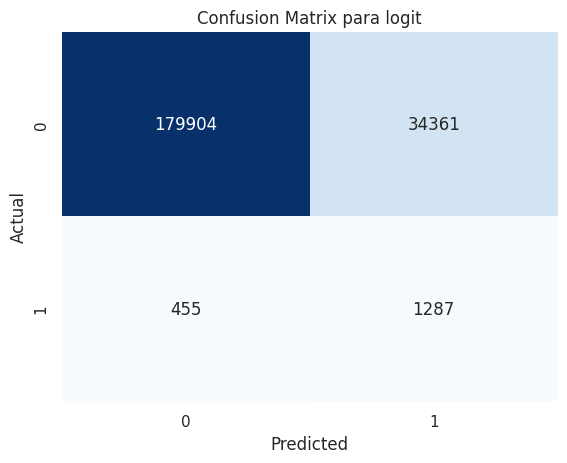

In [50]:
cm_logit_enero = confusion_matrix(y_test_enero, y_pred_logit_enero)
sns.heatmap(cm_logit_enero, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para logit")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Catboost Full

In [51]:
model_cat_enero = CatBoostClassifier(iterations=1500, depth=8, learning_rate=0.03, loss_function='Logloss')
model_cat_enero.fit(X_resampled_train_enero, y_resampled_train_enero, eval_set=(X_test_enero, y_test_enero), early_stopping_rounds=100, verbose=100)
y_pred_cat_enero = model_cat.predict(X_test_enero)

accuracy_cat_enero = accuracy_score(y_test_enero, y_pred_cat_enero)

print('Precisión del modelo:', round(accuracy_cat_enero,4))


print('Informe de clasificación:')

print(classification_report(y_test_enero, y_pred_cat_enero))

y_pred_proba_cat_enero = model_cat.predict_proba(X_test_enero)[:,1]
fpr_cat_enero, tpr_cat_enero, thresholds_cat_enero = roc_curve(y_test_enero, y_pred_proba_cat_enero)
auc_cat_enero = roc_auc_score(y_test_enero, y_pred_proba_cat_enero)

print("auc:",auc_cat)


0:	learn: 0.6621471	test: 0.6523310	best: 0.6523310 (0)	total: 321ms	remaining: 8m
100:	learn: 0.2940562	test: 0.2330466	best: 0.2330466 (100)	total: 33.3s	remaining: 7m 41s
200:	learn: 0.2558948	test: 0.2031199	best: 0.2031199 (200)	total: 1m 3s	remaining: 6m 52s
300:	learn: 0.2294722	test: 0.1825976	best: 0.1825976 (300)	total: 1m 34s	remaining: 6m 15s
400:	learn: 0.2109227	test: 0.1680852	best: 0.1680852 (400)	total: 2m 8s	remaining: 5m 53s
500:	learn: 0.1950818	test: 0.1561706	best: 0.1561706 (500)	total: 2m 39s	remaining: 5m 18s
600:	learn: 0.1820418	test: 0.1461231	best: 0.1461231 (600)	total: 3m 11s	remaining: 4m 46s
700:	learn: 0.1713129	test: 0.1378081	best: 0.1378081 (700)	total: 3m 41s	remaining: 4m 12s
800:	learn: 0.1600929	test: 0.1293556	best: 0.1293556 (800)	total: 4m 12s	remaining: 3m 40s
900:	learn: 0.1510285	test: 0.1223643	best: 0.1223643 (900)	total: 4m 44s	remaining: 3m 9s
1000:	learn: 0.1432629	test: 0.1167042	best: 0.1167042 (1000)	total: 5m 16s	remaining: 2m 37s

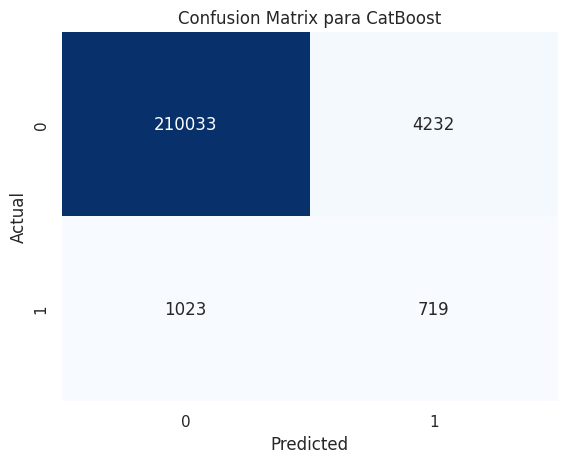

In [52]:
cm_cat_enero = confusion_matrix(y_test_enero, y_pred_cat_enero)
sns.heatmap(cm_cat_enero, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix para CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

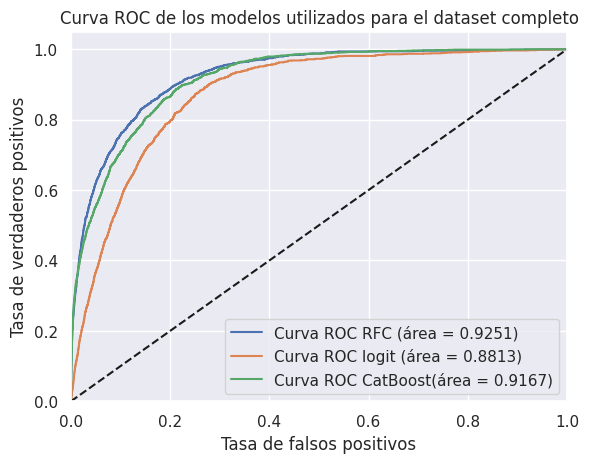

In [53]:
plt.plot(fpr_rfc_enero, tpr_rfc_enero, label='Curva ROC RFC (área = %0.4f)' % auc_rfc_enero)
plt.plot(fpr_logit_enero, tpr_logit_enero, label='Curva ROC logit (área = %0.4f)' % auc_logit_enero)
plt.plot(fpr_cat_enero, tpr_cat_enero, label='Curva ROC CatBoost(área = %0.4f)' % auc_cat_enero)


plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

# Etiquetas de los ejes y título

plt.xlabel('Tasa de falsos positivos')

plt.ylabel('Tasa de verdaderos positivos')

plt.title('Curva ROC de los modelos utilizados para el dataset completo')

plt.legend(loc="lower right")

# Mostrar la gráfica

plt.show()

##Procesamiento de coordenadas datos enero

In [54]:
enero_prom = pd.read_parquet("/content/df_enero_3_3_escenario_prom.parquet")
enero_desf = pd.read_parquet("/content/df_enero_3_3_escenario_desfav.parquet")
enero_fav = pd.read_parquet("/content/df_enero_3_3_escenario_fav.parquet")


In [55]:
src_crs = 'epsg:32718'
target_crs = 'epsg:4326'

# Create a Transformer for the coordinate conversion
transformer = Transformer.from_crs(src_crs, target_crs)

# Apply the coordinate conversion to the entire DataFrame
lon1, lat1 = transformer.transform(enero_prom['x'].values, enero_prom['y'].values)
lon2, lat2 = transformer.transform(enero_fav['x'].values, enero_fav['y'].values)
lon3, lat3 = transformer.transform(enero_desf['x'].values, enero_desf['y'].values)
# Add the new columns to the DataFrame

enero_desf["longitud"],enero_desf["latitud"] = lon3,lat3
enero_fav["longitud"],enero_fav["latitud"] = lon2,lat2
enero_prom["longitud"],enero_prom["latitud"] = lon1,lat1
# Print the resulting DataFrame with converted coordinates
enero_desf  = enero_desf.drop(["x","y"],axis=1)
enero_fav  = enero_fav.drop(["x","y"],axis=1)
enero_prom  = enero_prom.drop(["x","y"],axis=1)


## Enero Promedio

In [56]:
X_enero_prom = enero_prom.drop(["cuadrilla","geometry"], axis=1)
no_escalar_enero_prom = X_enero_prom[["dia","vegetation","longitud","latitud"]]
X_enero_prom = pd.DataFrame(MinMaxScaler().fit_transform(X_enero_prom.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X_holdout.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_enero_prom[["dia","vegetation","longitud","latitud"]] = no_escalar_enero_prom
X_enero_prom = X_enero_prom.reindex(columns=X_test.columns)


In [57]:
y_pred_rfc_enero_prom = model_rfc_enero.predict(X_enero_prom)
y_pred_logit_enero_prom = model_logit_enero.predict(X_enero_prom)
y_pred_cat_enero_prom = model_cat_enero.predict(X_enero_prom)


## Enero desfavorable

In [58]:
X_enero_desfav = enero_desf.drop(["cuadrilla","geometry"], axis=1)
no_escalar_enero_desfav = X_enero_desfav[["dia","vegetation","longitud","latitud"]]
X_enero_desfav = pd.DataFrame(MinMaxScaler().fit_transform(X_enero_desfav.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X_enero_desfav.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_enero_desfav[["dia","vegetation","longitud","latitud"]] = no_escalar_enero_desfav
X_enero_desfav = X_enero_desfav.reindex(columns=X_test.columns)

In [59]:
y_pred_rfc_enero_desfav = model_rfc_enero.predict(X_enero_desfav)
y_pred_logit_enero_desfav = model_logit_enero.predict(X_enero_desfav)
y_pred_cat_enero_desfav = model_cat_enero.predict(X_enero_desfav)




## Enero Favorable

In [60]:
X_enero_fav = enero_fav.drop(["cuadrilla","geometry"], axis=1)
no_escalar_enero_fav = X_enero_fav[["dia","vegetation","longitud","latitud"]]
X_enero_fav = pd.DataFrame(MinMaxScaler().fit_transform(X_enero_fav.drop(["dia","vegetation","longitud","latitud"],axis=1)), columns=X_enero_fav.drop(["dia","vegetation","longitud","latitud"],axis=1).columns)
X_enero_fav[["dia","vegetation","longitud","latitud"]] = no_escalar_enero_fav
X_enero_fav = X_enero_fav.reindex(columns=X_test.columns)

In [61]:
y_pred_rfc_enero_fav = model_rfc_enero.predict(X_enero_fav)
y_pred_logit_enero_fav = model_logit_enero.predict(X_enero_fav)
y_pred_cat_enero_fav = model_cat_enero.predict(X_enero_fav)


# Importancias

In [ ]:
"""explainer_catboost = shap.TreeExplainer(model_cat)
shap_values_catboost = explainer_catboost.shap_values(X_test[:100])"""

In [ ]:
"""explainer_logreg = shap.LinearExplainer(model_logit,X_test[:100])
shap_values_logreg = explainer_logreg.shap_values(X_test[:100])"""

In [ ]:
"""
# Get feature importances
feature_importances = pd.Series(model_rfc.feature_importances_, index=X_test.columns)

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title("Importancia de las variables RFC")
plt.show()
"""


In [ ]:
# CatBoostClassifier
#shap.summary_plot(shap_values_catboost, X_test[:100])


In [ ]:

# Logit
#shap.summary_plot(shap_values_logreg, X_test[:100])

In [ ]:
"""
shap_values_rf_holdout = explainer_rfc.shap_values(X_test_holdout[:100])

shap_values_logreg_holdout = explainer_logreg.shap_values(X_test_holdout[:100])


shap_values_catboost_holdout = explainer_catboost.shap_values(X_test_holdout[:100])
"""

In [ ]:
#shap.summary_plot(shap_values_logreg_holdout, X_test_holdout[:100])

In [ ]:
#shap.summary_plot(shap_values_catboost_holdout, X_test_holdout[:100])

In [ ]:
"""# Get feature importances
feature_importances = pd.Series(model_rfc.feature_importances_, index=X_test_holdout.columns)

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title("Importancia de las variables Random Forest en conjunto holdout")
plt.show()"""